<h2><center> Carbon Emissions Prediction in Africa Using Satellite Data </h2></center>
<figure>

![Methane Satellite](https://media.news.climate.columbia.edu/wp-content/uploads/2018/05/temperature-model.gif)
https://media.news.climate.columbia.edu/wp-content/uploads/2018/05/temperature-model.gif

## Overview
This project leverages open-source satellite data to predict carbon emissions across Africa. By combining data preprocessing, feature engineering, and advanced modeling techniques, we aim to provide a robust solution for monitoring carbon emissions in regions with limited ground-based measurements.

**Datasets:** Sentinel satellite data, ground truth emissions from GRACED and EDGAR.  
**Objective:** Predict weekly carbon emissions with minimal RMSE.  
**Evaluation Metric:** RMSE (Root Mean Squared Error)

*About the problem*
> The ability to accurately monitor carbon emissions is a critical step in the fight against climate change. Precise carbon readings allow researchers and governments to understand the sources and patterns of carbon mass output. While Europe and North America have extensive systems in place to monitor carbon emissions on the ground, there are few available in Africa.

*Objective of this challenge*
> The objective of this challenge is to create machine learning model using open-source CO2 emissions data (from Sentinel-5P satellite observations) to predict carbon emissions.

These solutions will enable EY, governments, and other actors to estimate carbon emission levels across Africa, even in places where on-the-ground monitoring is not possible.



## Table of contents:

1. [Installing and importing libraries](#Libraries)
2. [Loading data](#Data)
3. [Statistical summaries](#Statistics)
4. [Outliers](#Outliers)
5. [Geo Visualisation - EDA](#Geo)
5. [Missing values and duplicates](#Missing)
6. [Date features EDA](#Dates)
7. [Correlations - EDA](#Correlations)
9. [Timeseries visualization - EDA](#Timeseries)
10. [Feature engineering](#Engineering)
11. [Modelling](#Modelling)
12. [Making predictions of the test set and creating a submission file](#Predictions)

## Introduction
In this notebook, we document our approach to predicting carbon emissions in Africa using satellite data. We describe our data sources, preprocessing steps, feature engineering, model development, and evaluation processes. The final goal is to build a model with strong predictive performance (low RMSE) and create a submission file for evaluation.

<a name="Libraries"></a>
## 1. Installing and importing libraries


In [1]:
%%capture
# Install relevant libraries
#!pip install geopandas folium tqdm

In [2]:
# prompt: install and import light xgboost and xgboost

# Install lightgbm and xgboost
#!pip install lightgbm xgboost

# Import libraries
import lightgbm as lgb
import xgboost as xgb


In [3]:
# Import libraries
import pandas as pd
import numpy as np
import random
import os
from tqdm.notebook import tqdm

import geopandas as gpd
from shapely.geometry import Point
import folium

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_rows = None

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set seed for reproducability
SEED = 2023
random.seed(SEED)
np.random.seed(SEED)

<a name="Data"></a>
## 2. Loading and previewing data

In [5]:
DATA_PATH = ''
# Load files
train = pd.read_csv(os.path.join(DATA_PATH, 'Train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'Test.csv'))
samplesubmission = pd.read_csv(os.path.join(DATA_PATH, 'SampleSubmission.csv'))

# Preview train dataset
train.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-23.73_28.77_2019_1,-23.73000,28.77000,2019,1,0.00017,0.71317,0.00010,0.22393,24.93944,...,5566.22202,54826.03262,4606.21000,19.11528,0.35378,24.95195,49.05395,-89.63803,17.98887,86.05170
1,ID_-23.73_28.77_2019_2,-23.73000,28.77000,2019,2,-0.00016,0.81291,-0.00014,0.08028,16.62416,...,3711.51136,68491.75334,3034.46166,12.21866,0.24499,4.70886,42.58668,-89.90431,22.77325,88.87567
2,ID_-23.73_28.77_2019_3,-23.73000,28.77000,2019,3,-0.00007,0.86031,-0.00006,0.16105,-13.23724,...,2136.38519,78967.73955,1433.48259,6.06274,0.24510,76.06063,34.73754,-83.59525,17.43730,91.72311
3,ID_-23.73_28.77_2019_4,-23.73000,28.77000,2019,4,0.00015,0.42228,0.00009,0.04650,-13.53465,...,3841.85302,64592.80677,2878.51292,6.38823,0.21090,75.91237,60.29449,-71.89673,11.97782,92.88387
4,ID_-23.73_28.77_2019_5,-23.73000,28.77000,2019,5,0.00002,1.00458,0.00003,0.21425,-13.47572,...,1295.68817,86804.02539,1094.66534,9.20625,0.26110,-13.34608,50.19449,-77.46208,24.37427,94.87833


In [6]:
# Preview test dataset
test.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,ID_-23.53_27.47_2019_1,-23.53000,27.47000,2019,1,0.00008,0.45447,0.00003,0.11429,-80.28631,...,74897.05200,2180.26654,81287.07448,1562.03102,10.73412,0.28066,-31.23017,33.33797,-93.21726,23.35825
1,ID_-23.53_27.47_2019_2,-23.53000,27.47000,2019,2,0.00018,0.42317,0.00006,0.07510,-17.76569,...,84222.65352,982.61906,90307.65001,927.11122,5.25002,0.23893,66.49090,58.13779,-85.00147,13.41648
2,ID_-23.53_27.47_2019_3,-23.53000,27.47000,2019,3,0.00006,0.71309,0.00004,0.11421,16.72565,...,78922.49079,1582.96493,85383.15185,1006.77811,6.81937,0.25868,75.92319,41.33695,-83.26754,16.27300
3,ID_-23.53_27.47_2019_4,-23.53000,27.47000,2019,4,0.00048,0.43445,0.00017,0.13139,-22.47534,...,61135.91959,3935.41998,67490.03136,3428.42353,6.23363,0.28154,-11.02323,60.68987,-77.76372,22.79396
4,ID_-23.53_27.47_2019_5,-23.53000,27.47000,2019,5,0.00019,0.78304,0.00014,0.16114,4.75036,...,78494.24739,1647.53853,84478.74304,1122.53409,11.81025,0.28156,-13.29451,51.00713,-76.62065,23.19824


In [7]:
# Preview sample submission file
samplesubmission.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-23.53_27.47_2019_1,0
1,ID_-23.53_27.47_2019_2,0
2,ID_-23.53_27.47_2019_3,0
3,ID_-23.53_27.47_2019_4,0
4,ID_-23.53_27.47_2019_5,0


In [8]:
# Check size and shape of datasets
train.shape, test.shape, samplesubmission.shape

((74005, 76), (28085, 75), (28085, 2))

In [9]:
# Train to test sets ratio
(test.shape[0]) / (train.shape[0] + test.shape[0])

0.2751004016064257

## Exploratory Data Analysis (EDA)

In this section, we explore the dataset to understand its structure, distributions, and potential anomalies. We will visualize key variables, inspect summary statistics, and identify any issues (e.g., missing values or outliers) that need to be addressed.


<a name="Statistics"></a>
## 3. Statistical summaries

In [10]:
# Train statistical summary
train.describe(include = 'all')

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
count,74005,74005.00000,74005.00000,74005.00000,74005.00000,72075.00000,72075.00000,72075.00000,72075.00000,72075.00000,...,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,74005.00000
unique,74005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ID_-33.93_25.67_2022_52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,-27.82972,27.78274,2020.47805,26.15610,0.00026,0.51587,0.00009,0.10569,4.48763,...,3652.34972,74390.62446,2871.26282,15.82539,0.22544,-14.27712,49.56784,-50.51322,40.55896,7891.06097
std,NaN,2.76059,2.74667,1.11126,14.84384,0.00060,0.19677,0.00020,0.06955,52.24654,...,1807.38528,12859.06733,1645.82767,19.69665,0.06313,47.27732,12.09742,20.62391,12.20118,52571.60466
min,NaN,-33.93000,21.07000,2019.00000,1.00000,-0.00099,0.13374,-0.00083,0.00000,-110.02766,...,128.29979,14541.97799,10.30036,1.15114,0.00000,-125.29806,0.10088,-97.57091,10.90623,0.04806
25%,NaN,-29.63000,26.67000,2019.00000,13.00000,-0.00007,0.37174,-0.00003,0.05248,-18.17813,...,2260.91745,65920.34050,1602.61523,5.07185,0.18349,-31.95209,41.32913,-67.98772,29.78659,154.54720
50%,NaN,-28.13000,28.77000,2020.00000,26.00000,0.00015,0.48869,0.00007,0.09951,-10.98754,...,3437.87891,75994.80202,2563.92629,8.60904,0.22350,-13.73803,53.23303,-45.41392,40.11757,723.13586
75%,NaN,-25.73000,29.47000,2021.00000,39.00000,0.00044,0.62353,0.00019,0.15248,59.11999,...,4745.60794,84409.69113,3819.67139,17.47863,0.26772,3.79039,59.47813,-33.12496,51.44570,2773.02930


From the above statistical summary, we can deduce some of the following insights:
 - The train data provided ranges from year *2019 to 2022*
 - Minimum recorded CO2 emissions is *0.04806* and a maximum of *1181701.2*
 - Week of the year starts from 1 to 52
 - The latitude and longitudes ranges show that the regions are mostly within South Africa

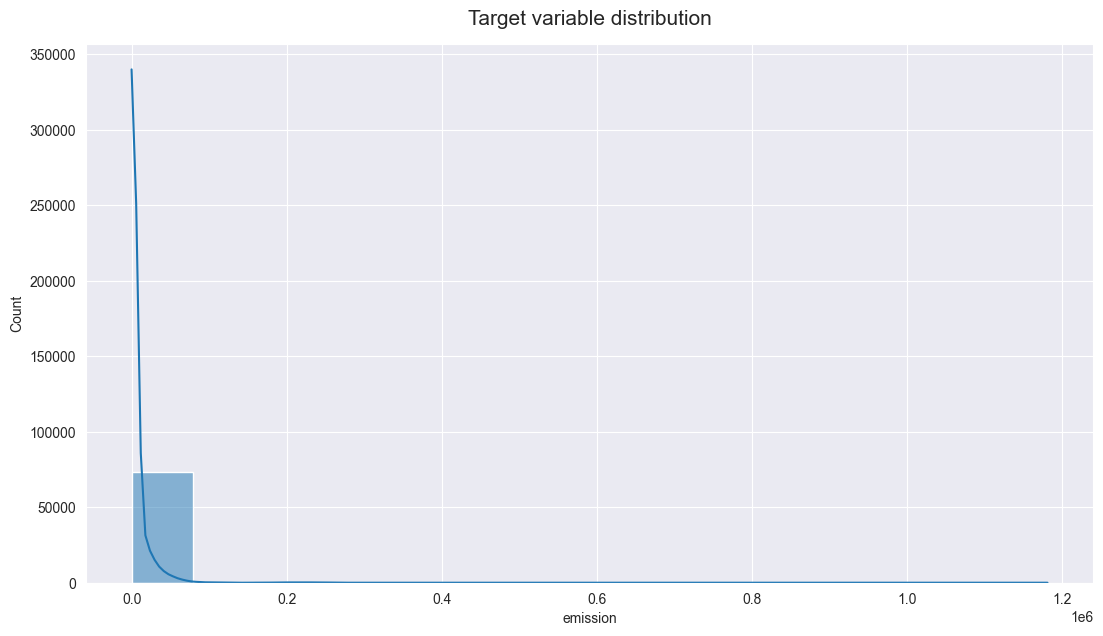

None

np.float64(17.038027449698163)

In [11]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(train.emission, kde = True, bins = 15)
plt.title('Target variable distribution', y = 1.02, fontsize = 15)
display(plt.show(), train.emission.skew())

The target variable is skewed to the right with a a degree of ~17.

Some of the techniques used to handle skewness include:
- Log transform
- Box-cox transform
- Square root transform
- *etc*

<a name="Outliers"></a>
## 4. Outliers


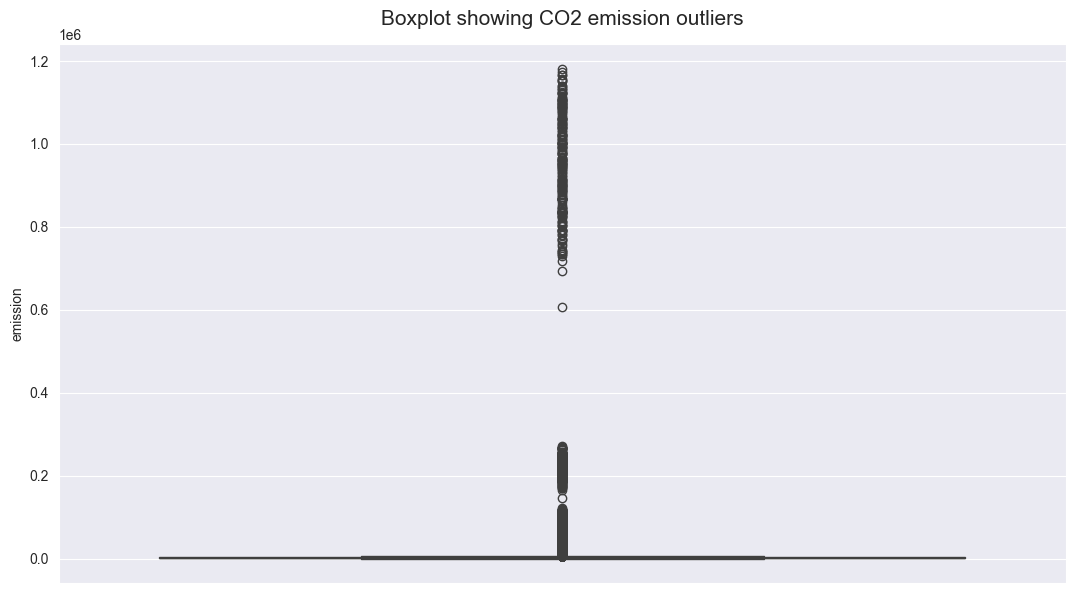

In [12]:
# Plotting boxplot for the CO2 emissions
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.boxplot(train.emission)
plt.title('Boxplot showing CO2 emission outliers', y = 1.02, fontsize = 15)
plt.show()

Outliers are those data points which differ significantly from other observations present in given dataset.

Suggestions on how to handle outliers:
 - Transforming the outliers by scaling - log transformation, box-cox transformation ...
 - Dropping outliers
 - Imputation by replacing outliers with mean, median ...


## Data Preprocessing

In this section, we clean and prepare our data for modeling. This includes handling missing values, treating outliers, and applying necessary transformations (such as log transformations) to stabilize variance and normalize distributions.

### Handling outliers and Missing values

In [13]:
# -------------------------------
# Step 1: Outlier Treatment via Winsorization (Capping)
# -------------------------------
# Compute the 1st and 99th percentiles from the training data.
lower_bound = train['emission'].quantile(0.01)
upper_bound = train['emission'].quantile(0.99)
print("Lower bound (1st percentile):", lower_bound)
print("Upper bound (99th percentile):", upper_bound)

# Apply winsorization: values below lower_bound are set to lower_bound,
# and values above upper_bound are set to upper_bound.
train['emission_winsor'] = train['emission'].clip(lower=lower_bound, upper=upper_bound)

# If the test dataset contains the emission column, apply the same transformation.
if 'emission' in test.columns:
    test['emission_winsor'] = test['emission'].clip(lower=lower_bound, upper=upper_bound)

Lower bound (1st percentile): 0.67438868
Upper bound (99th percentile): 66961.65816000054


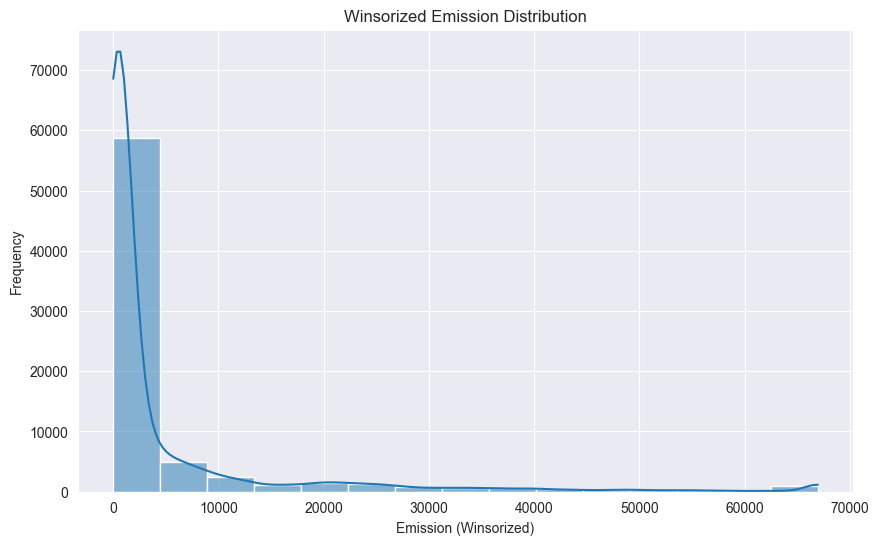

In [14]:
# Visualize the distribution after winsorization.
plt.figure(figsize=(10, 6))
sns.histplot(train['emission_winsor'], kde=True, bins=15)
plt.title('Winsorized Emission Distribution')
plt.xlabel('Emission (Winsorized)')
plt.ylabel('Frequency')
plt.show()

In [15]:
# -------------------------------
# Step 2: Log Transformation
# -------------------------------
# Use np.log1p to compute log(1 + x) which safely handles zeros.
train['emission_log'] = np.log1p(train['emission_winsor'])

# If test has the winsorized target, transform it as well.
if 'emission_winsor' in test.columns:
    test['emission_log'] = np.log1p(test['emission_winsor'])

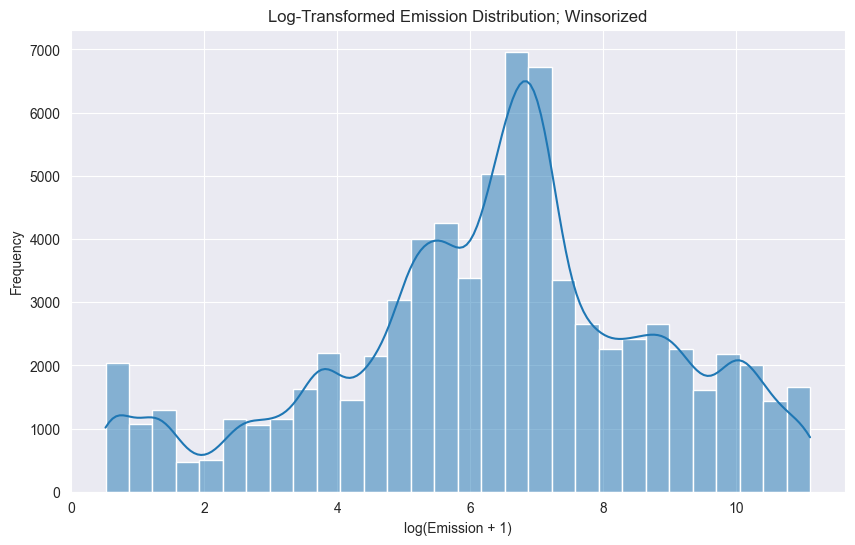

In [16]:
# Visualize the log-transformed distribution.
plt.figure(figsize=(10, 6))
sns.histplot(train['emission_log'], kde=True, bins=30)
plt.title('Log-Transformed Emission Distribution; Winsorized')
plt.xlabel('log(Emission + 1)')
plt.ylabel('Frequency')
plt.show()

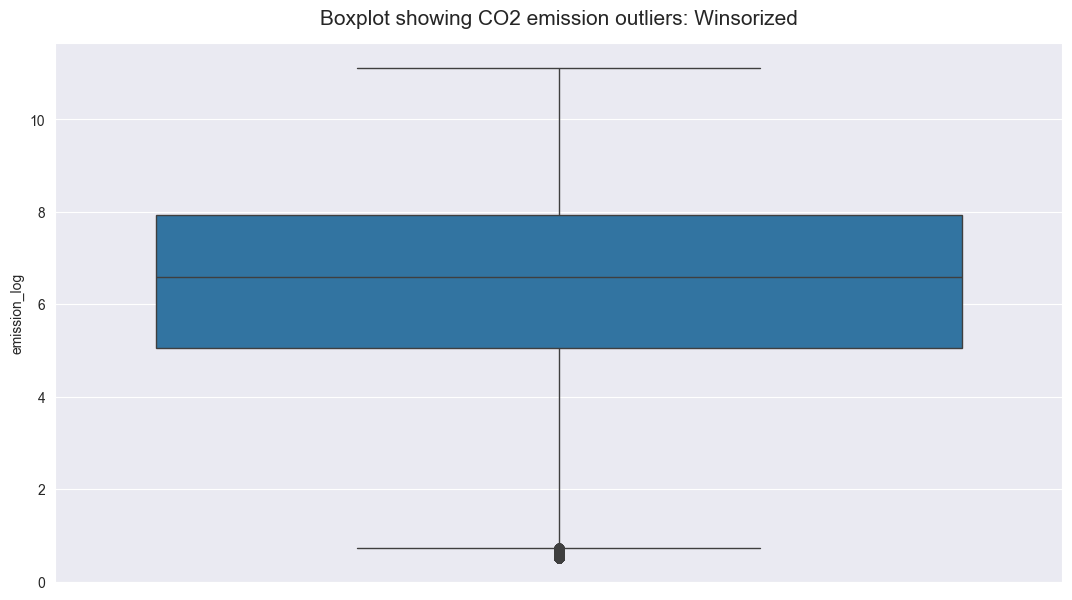

In [17]:
# Plotting boxplot for the CO2 emissions
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.boxplot(train.emission_log)
plt.title('Boxplot showing CO2 emission outliers: Winsorized', y = 1.02, fontsize = 15)
plt.show()

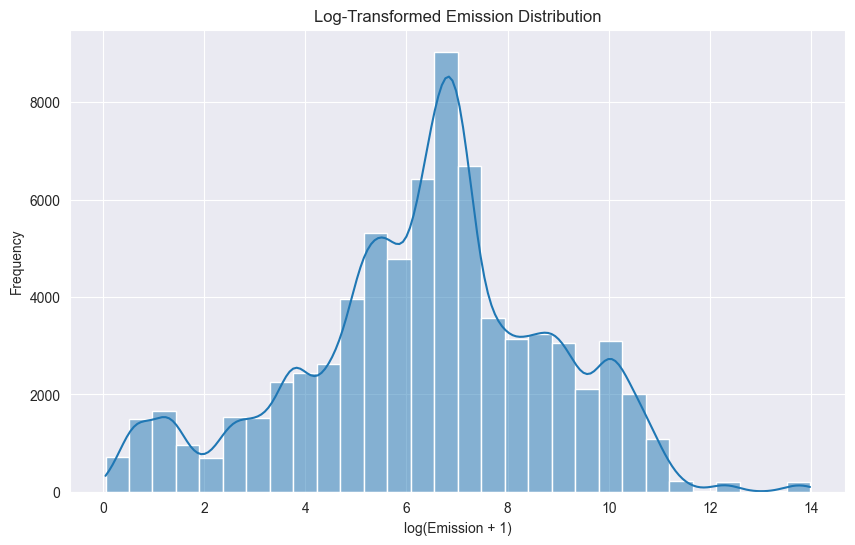

In [18]:
# Visualize the log-transformed distribution. NB: Without winsoring
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(train['emission']), kde=True, bins=30)
plt.title('Log-Transformed Emission Distribution')
plt.xlabel('log(Emission + 1)')
plt.ylabel('Frequency')
plt.show()

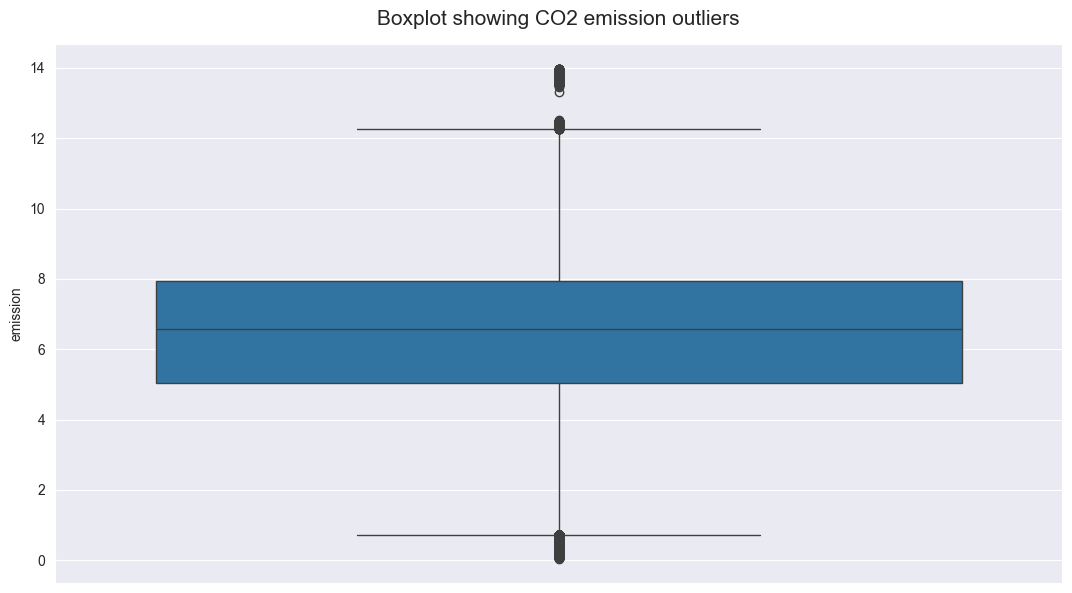

In [19]:
# Plotting boxplot for the CO2 emissions NB: Without winsoring
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.boxplot(np.log1p(train['emission']))
plt.title('Boxplot showing CO2 emission outliers', y = 1.02, fontsize = 15)
plt.show()

<a name="Geo"></a>
## 5. Geo Visualisation - EDA

In [20]:
# Combine train and test for easy visualisation
train_coords = train.drop_duplicates(subset = ['latitude', 'longitude'])
test_coords = test.drop_duplicates(subset = ['latitude', 'longitude'])
train_coords['set_type'], test_coords['set_type'] = 'train', 'test'

all_data = pd.concat([train_coords, test_coords], ignore_index = True)
# Create point geometries

geometry = gpd.points_from_xy(all_data.longitude, all_data.latitude)
geo_df = gpd.GeoDataFrame(
    all_data[["latitude", "longitude", "set_type"]], geometry=geometry
)

# Preview the geopandas df
geo_df.head()

,latitude,longitude,set_type,geometry
0,-23.73000,28.77000,train,POINT (28.77 -23.73)
1,-23.73000,28.87000,train,POINT (28.87 -23.73)
2,-23.73000,28.97000,train,POINT (28.97 -23.73)
3,-23.73000,29.07000,train,POINT (29.07 -23.73)
4,-23.73000,29.17000,train,POINT (29.17 -23.73)


In [21]:
# Create a canvas to plot your map on
all_data_map = folium.Map(prefer_canvas=True)

# Create a geometry list from the GeoDataFrame
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry]

# Iterate through list and add a marker for each volcano, color-coded by its type.
i = 0
for coordinates in geo_df_list:
    # assign a color marker for the type set
    if geo_df.set_type[i] == "train":
        type_color = "green"
    elif geo_df.set_type[i] == "test":
        type_color = "orange"

    # Place the markers
    all_data_map.add_child(
        folium.CircleMarker(
            location=coordinates,
            radius = 1,
            weight = 4,
            zoom =10,
            popup=
            "Set: " + str(geo_df.set_type[i]) + "<br>"
            "Coordinates: " + str([round(x, 2) for x in geo_df_list[i]]),
            color =  type_color),
        )
    i = i + 1
all_data_map.fit_bounds(all_data_map.get_bounds())
all_data_map

<a name="Missing"></a>
## 6. Missing values and duplicates

In [22]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any()

(np.True_, np.True_)

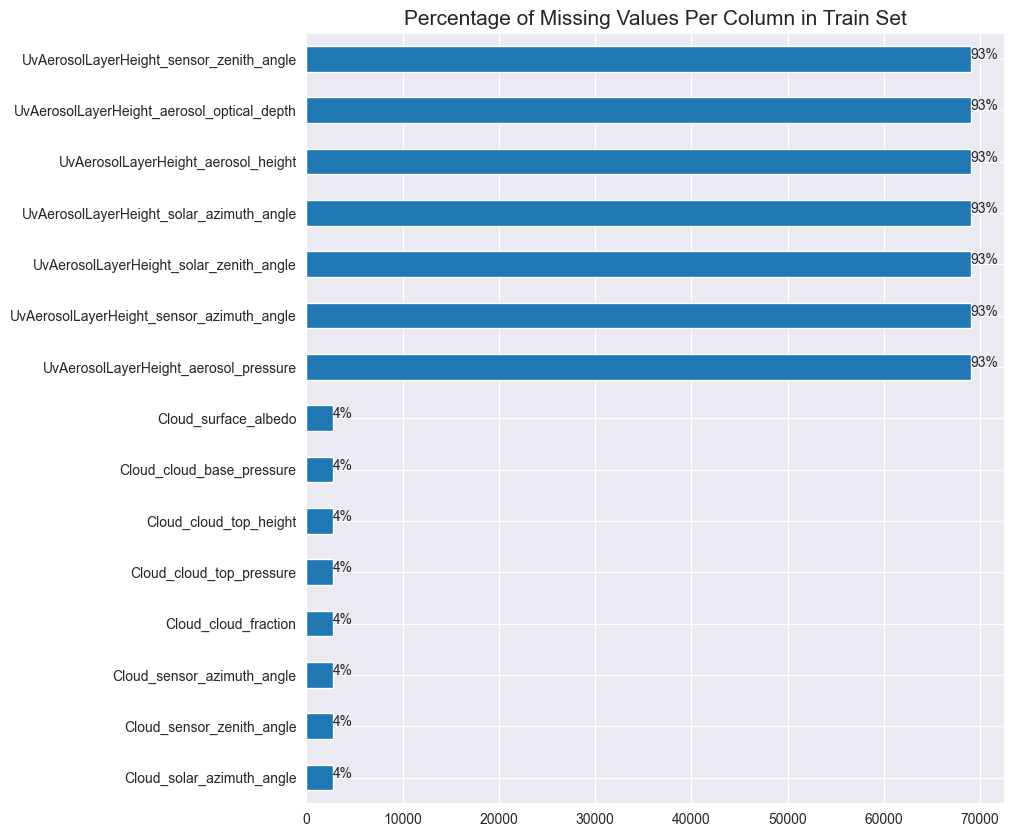

In [23]:
# Plot missing values in train set
ax = train.isna().sum().sort_values(ascending = False)[:15][::-1].plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

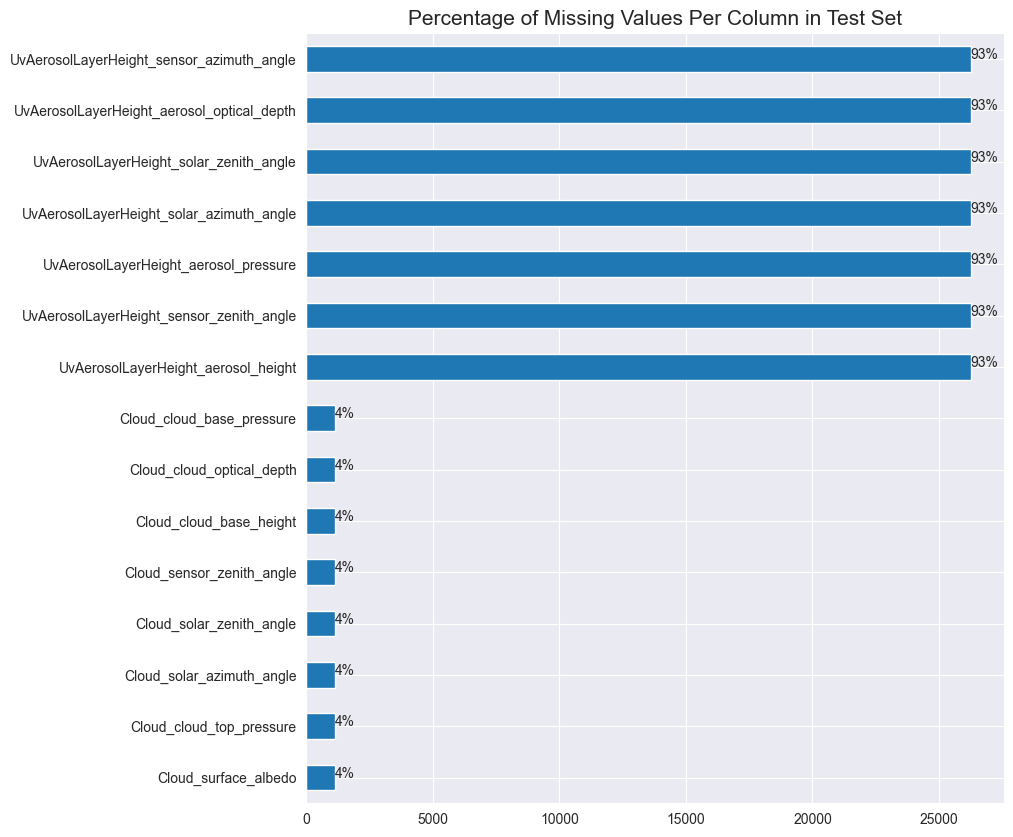

In [24]:
# Plot missing values in test set
ax = test.isna().sum().sort_values(ascending = False)[:15][::-1].plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/test.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

Suggestions on how to handle missing values:
 - Fill in missing values with mode, mean, median..
 - Drop Missing datapoints with missing values
 - Fill in with a large number e.g -999999

### Handling missing values

In [25]:
# List of columns to drop
cols_to_drop = [
    "UvAerosolLayerHeight_aerosol_height",
    "UvAerosolLayerHeight_aerosol_pressure",
    "UvAerosolLayerHeight_aerosol_optical_depth",
    "UvAerosolLayerHeight_sensor_zenith_angle",
    "UvAerosolLayerHeight_sensor_azimuth_angle",
    "UvAerosolLayerHeight_solar_azimuth_angle",
    "UvAerosolLayerHeight_solar_zenith_angle"
]

# Drop the specified columns from the train dataset if they exist
train.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Drop the specified columns from the test dataset if they exist
test.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Check remaining columns in both datasets
print("Remaining columns in train dataset:", train.columns.tolist())
print("Remaining columns in test dataset:", test.columns.tolist())


Remaining columns in train dataset: ['ID_LAT_LON_YEAR_WEEK', 'latitude', 'longitude', 'year', 'week_no', 'SulphurDioxide_SO2_column_number_density', 'SulphurDioxide_SO2_column_number_density_amf', 'SulphurDioxide_SO2_slant_column_number_density', 'SulphurDioxide_cloud_fraction', 'SulphurDioxide_sensor_azimuth_angle', 'SulphurDioxide_sensor_zenith_angle', 'SulphurDioxide_solar_azimuth_angle', 'SulphurDioxide_solar_zenith_angle', 'SulphurDioxide_SO2_column_number_density_15km', 'CarbonMonoxide_CO_column_number_density', 'CarbonMonoxide_H2O_column_number_density', 'CarbonMonoxide_cloud_height', 'CarbonMonoxide_sensor_altitude', 'CarbonMonoxide_sensor_azimuth_angle', 'CarbonMonoxide_sensor_zenith_angle', 'CarbonMonoxide_solar_azimuth_angle', 'CarbonMonoxide_solar_zenith_angle', 'NitrogenDioxide_NO2_column_number_density', 'NitrogenDioxide_tropospheric_NO2_column_number_density', 'NitrogenDioxide_stratospheric_NO2_column_number_density', 'NitrogenDioxide_NO2_slant_column_number_density', 'N

In [26]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()

(np.False_, np.False_)

Below is a code snippet that first generates histograms for all columns (except the target "emission" and unique id "ID_LAT_LON_YEAR_WEEK") so you can visually inspect each variable’s distribution. Then it automatically selects an imputation strategy for numeric variables—using the mean if the distribution is roughly symmetric (absolute skew ≤ 1) and the median if it is skewed (absolute skew > 1)—and uses the mode for categorical variables. The imputation values computed on the training data are then applied to both the train and test sets.

In [27]:
# List columns to exclude
exclude_cols = ['emission', 'ID_LAT_LON_YEAR_WEEK','latitude','longitude','year','week_no']

# Separate numeric and categorical columns (excluding the ones to drop)
numeric_cols = [col for col in train.select_dtypes(include=[np.number]).columns if col not in exclude_cols]
categorical_cols = [col for col in train.select_dtypes(include=['object']).columns if col not in exclude_cols]

In [28]:
# -------------------------------
# Part 1: Visualize Histograms for Numeric Variables
# -------------------------------
# print("Histograms for Numeric Variables:")
# for col in numeric_cols:
#     plt.figure(figsize=(8, 4))
#     sns.histplot(train[col].dropna(), kde=True, bins=30)
#     plt.title(f"Distribution of {col}\nSkewness: {train[col].skew():.2f}")
#     plt.xlabel(col)
#     plt.ylabel("Frequency")
#     plt.show()

In [29]:
# -------------------------------
# Part 2: Visualize Histograms for Categorical Variables
# -------------------------------
print("Bar Plots for Categorical Variables:")
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    train[col].value_counts().plot(kind='bar')
    plt.title(f"Value Counts of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

Bar Plots for Categorical Variables:


In [30]:
# -------------------------------
# Part 3: Compute Imputation Values based on Distribution
# -------------------------------

# For numeric columns: decide between mean (if symmetric) and median (if skewed)
num_impute_values = {}
for col in numeric_cols:
    skewness = train[col].skew()
    if abs(skewness) > 1:
        impute_val = train[col].median()
        strategy = 'median'
    else:
        impute_val = train[col].mean()
        strategy = 'mean'
    num_impute_values[col] = impute_val
    print(f"Numeric Column: {col} | Skewness: {skewness:.2f} | Imputation Strategy: {strategy} | Value: {impute_val}")

# For categorical columns: impute with mode
cat_impute_values = {}
for col in categorical_cols:
    mode_val = train[col].mode()[0]
    cat_impute_values[col] = mode_val
    print(f"Categorical Column: {col} | Mode: {mode_val}")

Numeric Column: SulphurDioxide_SO2_column_number_density | Skewness: 2.84 | Imputation Strategy: median | Value: 0.000146891718
Numeric Column: SulphurDioxide_SO2_column_number_density_amf | Skewness: 0.95 | Imputation Strategy: mean | Value: 0.5158747002847991
Numeric Column: SulphurDioxide_SO2_slant_column_number_density | Skewness: 0.96 | Imputation Strategy: mean | Value: 9.10365142153243e-05
Numeric Column: SulphurDioxide_cloud_fraction | Skewness: 0.41 | Imputation Strategy: mean | Value: 0.10568985294336715
Numeric Column: SulphurDioxide_sensor_azimuth_angle | Skewness: -0.20 | Imputation Strategy: mean | Value: 4.487626551735284
Numeric Column: SulphurDioxide_sensor_zenith_angle | Skewness: -0.49 | Imputation Strategy: mean | Value: 45.3247300750852
Numeric Column: SulphurDioxide_solar_azimuth_angle | Skewness: -0.42 | Imputation Strategy: mean | Value: -47.824449430214784
Numeric Column: SulphurDioxide_solar_zenith_angle | Skewness: -0.17 | Imputation Strategy: mean | Value: 3

Numeric Column: Formaldehyde_tropospheric_HCHO_column_number_density_amf | Skewness: 1.24 | Imputation Strategy: median | Value: 0.9949204827
Numeric Column: Formaldehyde_HCHO_slant_column_number_density | Skewness: 0.13 | Imputation Strategy: mean | Value: 6.385285503341942e-05
Numeric Column: Formaldehyde_cloud_fraction | Skewness: 0.65 | Imputation Strategy: mean | Value: 0.15440645267837513
Numeric Column: Formaldehyde_solar_zenith_angle | Skewness: -0.04 | Imputation Strategy: mean | Value: 40.57748412341327
Numeric Column: Formaldehyde_solar_azimuth_angle | Skewness: -0.63 | Imputation Strategy: mean | Value: -49.70059599321253
Numeric Column: Formaldehyde_sensor_zenith_angle | Skewness: -0.71 | Imputation Strategy: mean | Value: 47.74669557358119
Numeric Column: Formaldehyde_sensor_azimuth_angle | Skewness: 0.20 | Imputation Strategy: mean | Value: -10.591117372046863
Numeric Column: UvAerosolIndex_absorbing_aerosol_index | Skewness: 0.51 | Imputation Strategy: mean | Value: -0.

In [31]:
# -------------------------------
# Part 4: Apply Imputation to Train and Test Sets
# -------------------------------

# Impute numeric columns in train and test
for col, value in num_impute_values.items():
    train[col].fillna(value, inplace=True)
    if col in test.columns:
        test[col].fillna(value, inplace=True)

# Impute categorical columns in train and test
for col, value in cat_impute_values.items():
    train[col].fillna(value, inplace=True)
    if col in test.columns:
        test[col].fillna(value, inplace=True)

In [32]:
# Verification: Check if any missing values remain
print("\nAfter imputation:")
print("Missing values in Train (numeric):", train[numeric_cols].isnull().sum().sum())
print("Missing values in Train (categorical):", train[categorical_cols].isnull().sum().sum())
# print("Missing values in Test (numeric):", test[numeric_cols].isnull().sum().sum())
print("Missing values in Test (categorical):", test[categorical_cols].isnull().sum().sum())


After imputation:
Missing values in Train (numeric): 0
Missing values in Train (categorical): 0.0
Missing values in Test (categorical): 0.0


((74005, 76), (28085, 75), (28085, 2))

<a name="Dates"></a>
## 7. Date features EDA

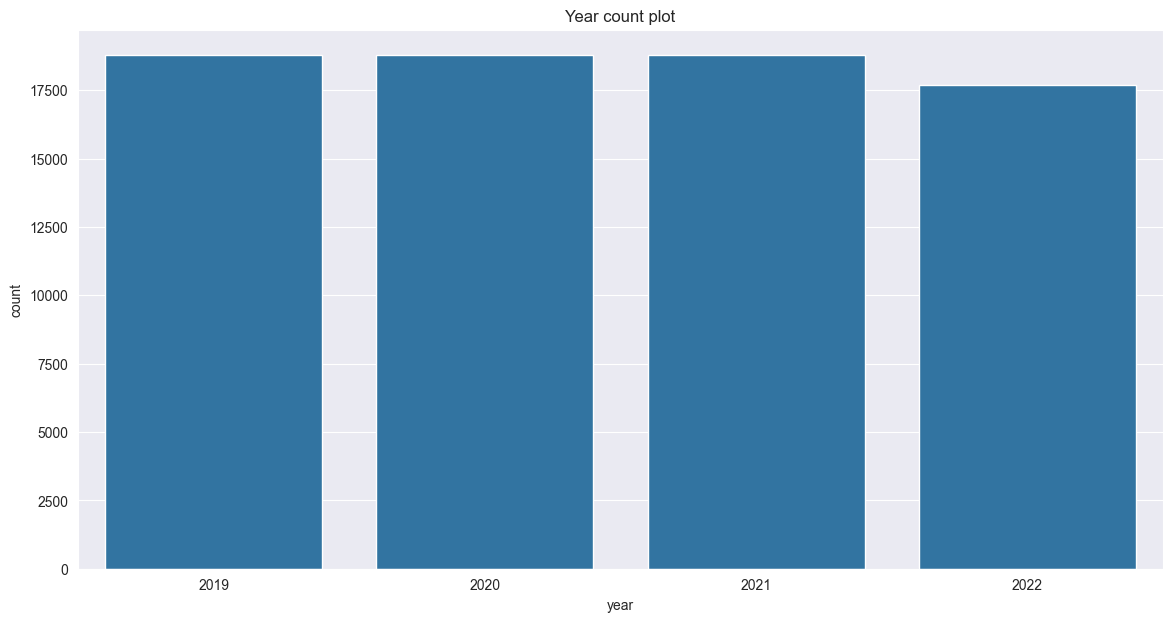

In [33]:
# Year countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'year', data = train)
plt.title('Year count plot')
plt.show()

- The number of observations of CO2 emissions are relatively the same across the years
- Year 2022 has fewer number of observations

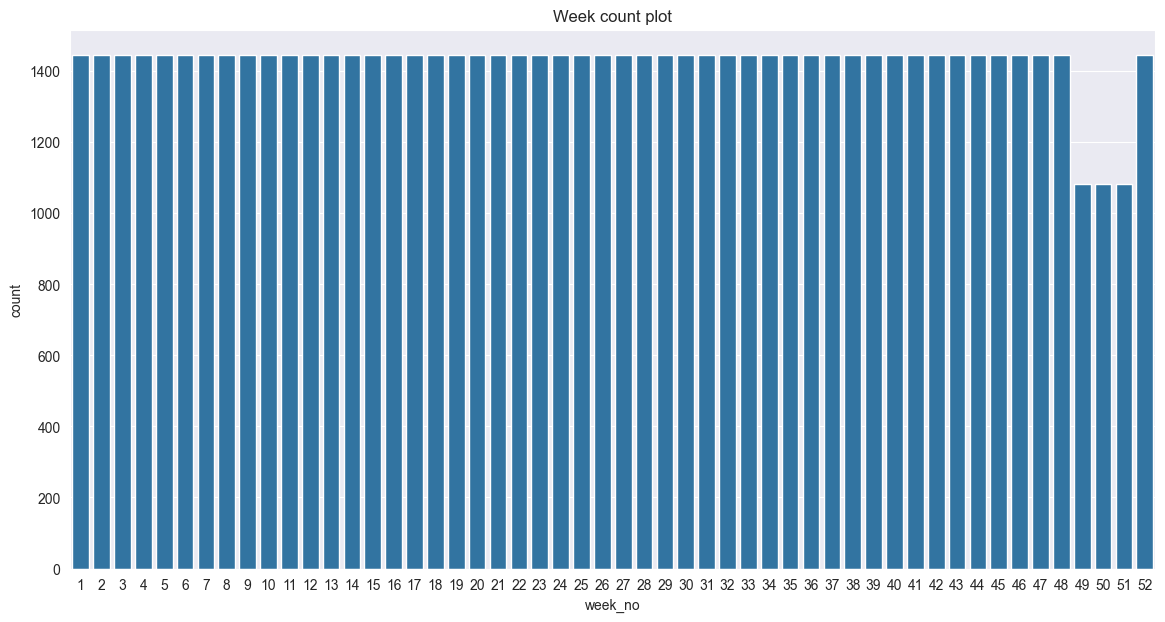

In [34]:
# Week countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'week_no', data = train)
plt.title('Week count plot')
plt.show()

- The number of observations of CO2 emissions are relatively the same across the weeks
- Weeks 49, 50 and 51  have fewer number of observations when compared to the other weeks

In [35]:
train.drop_duplicates(subset = ['year', 'week_no']).groupby(['year'])[['week_no']].count()

,week_no
year,
2019,52
2020,52
2021,52
2022,49


- The year 2022 has only 49 weeks available in the data

<a name="Correlations"></a>
## 8. Correlations - EDA

In [36]:
# # Top 20 correlated features to the target
# top20_corrs = abs(train.corr()['emission']).sort_values(ascending = False).head(20)
# top20_corrs

# Define the columns to exclude (non-numeric columns and others)
exclude_cols = ['emission', 'ID_LAT_LON_YEAR_WEEK', 'latitude', 'longitude', 'year', 'week_no']

# Identify numeric columns from the train dataset, excluding the ones above.
numeric_features = [col for col in train.select_dtypes(include=[np.number]).columns if col not in exclude_cols]

# Ensure that the target 'emission' is included (if not already)
if 'emission' not in numeric_features:
    numeric_features.append('emission')

# Compute the correlation matrix using only these numeric columns.
corr_matrix = train[numeric_features].corr()

#Get the top 20 correlated features with the target 'emission'
top20_corrs = abs(corr_matrix['emission']).sort_values(ascending=False).head(20)
print(top20_corrs)


emission                                                 1.00000
emission_winsor                                          0.52151
NitrogenDioxide_NO2_column_number_density                0.28098
NitrogenDioxide_tropospheric_NO2_column_number_density   0.27676
emission_log                                             0.24469
NitrogenDioxide_NO2_slant_column_number_density          0.23838
SulphurDioxide_SO2_column_number_density_15km            0.07087
SulphurDioxide_SO2_slant_column_number_density           0.06484
SulphurDioxide_SO2_column_number_density                 0.05833
Cloud_surface_albedo                                     0.05701
UvAerosolIndex_sensor_altitude                           0.04477
NitrogenDioxide_sensor_altitude                          0.03977
CarbonMonoxide_sensor_altitude                           0.03761
SulphurDioxide_SO2_column_number_density_amf             0.03115
CarbonMonoxide_H2O_column_number_density                 0.02473
Formaldehyde_HCHO_slant_c

In [37]:
# #Plotting correlation heatmap for all the numeric variables
# plt.figure(figsize=(10,6))
# sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap="coolwarm", linewidths=0.5)
# plt.title("Feature Correlation Matrix")
# plt.show()

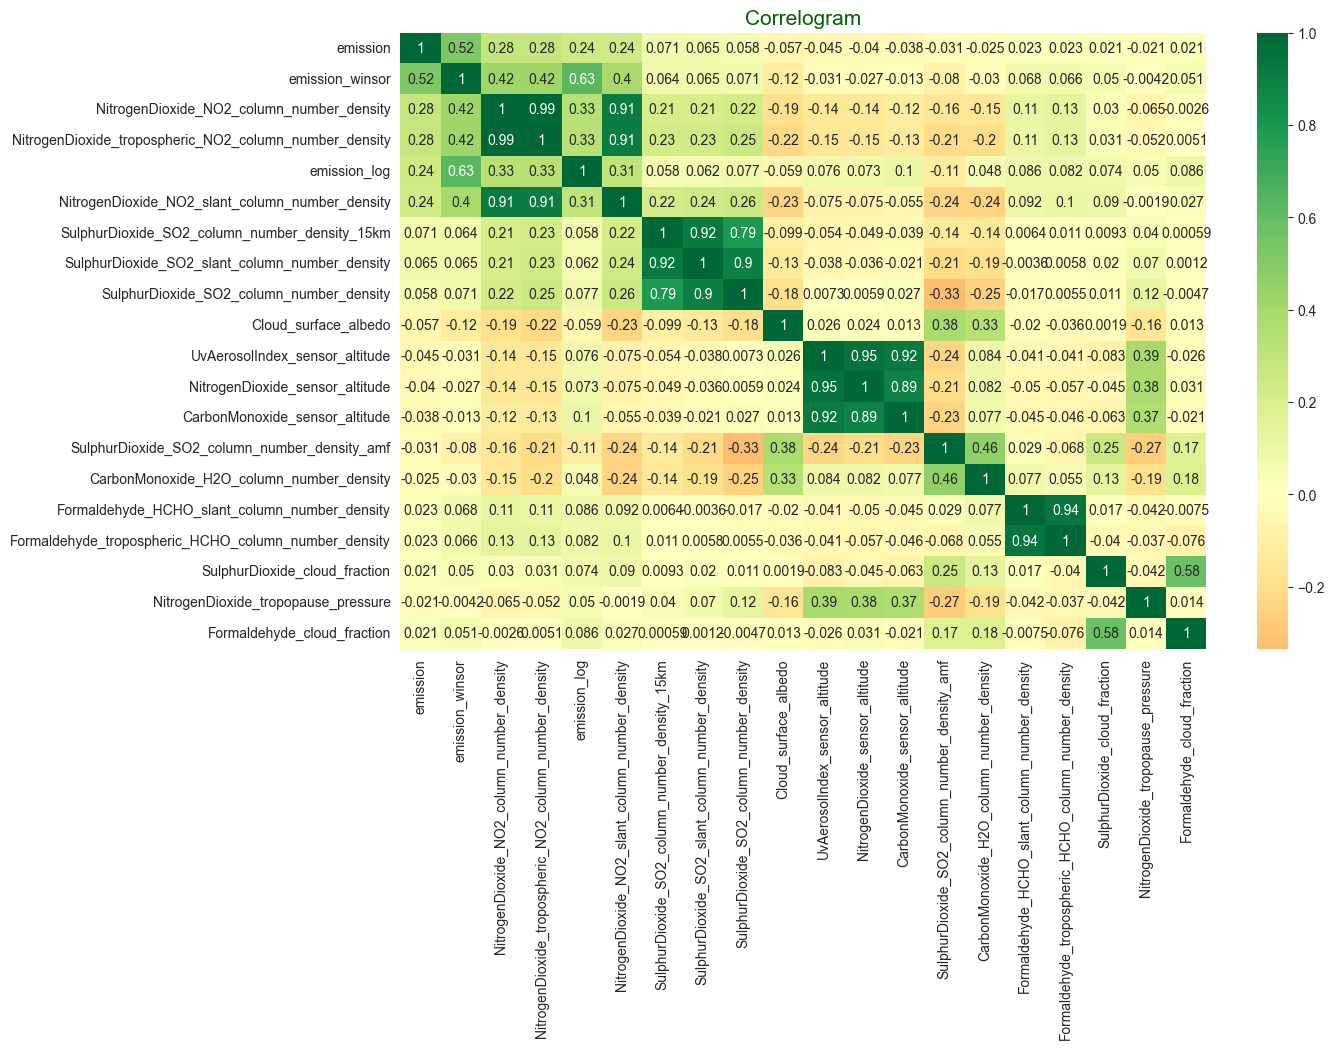

In [38]:
# Quantify correlations between features
corr = train[list(top20_corrs.index)].corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

<a name="Timeseries"></a>
## 9. Timeseries visualization - EDA

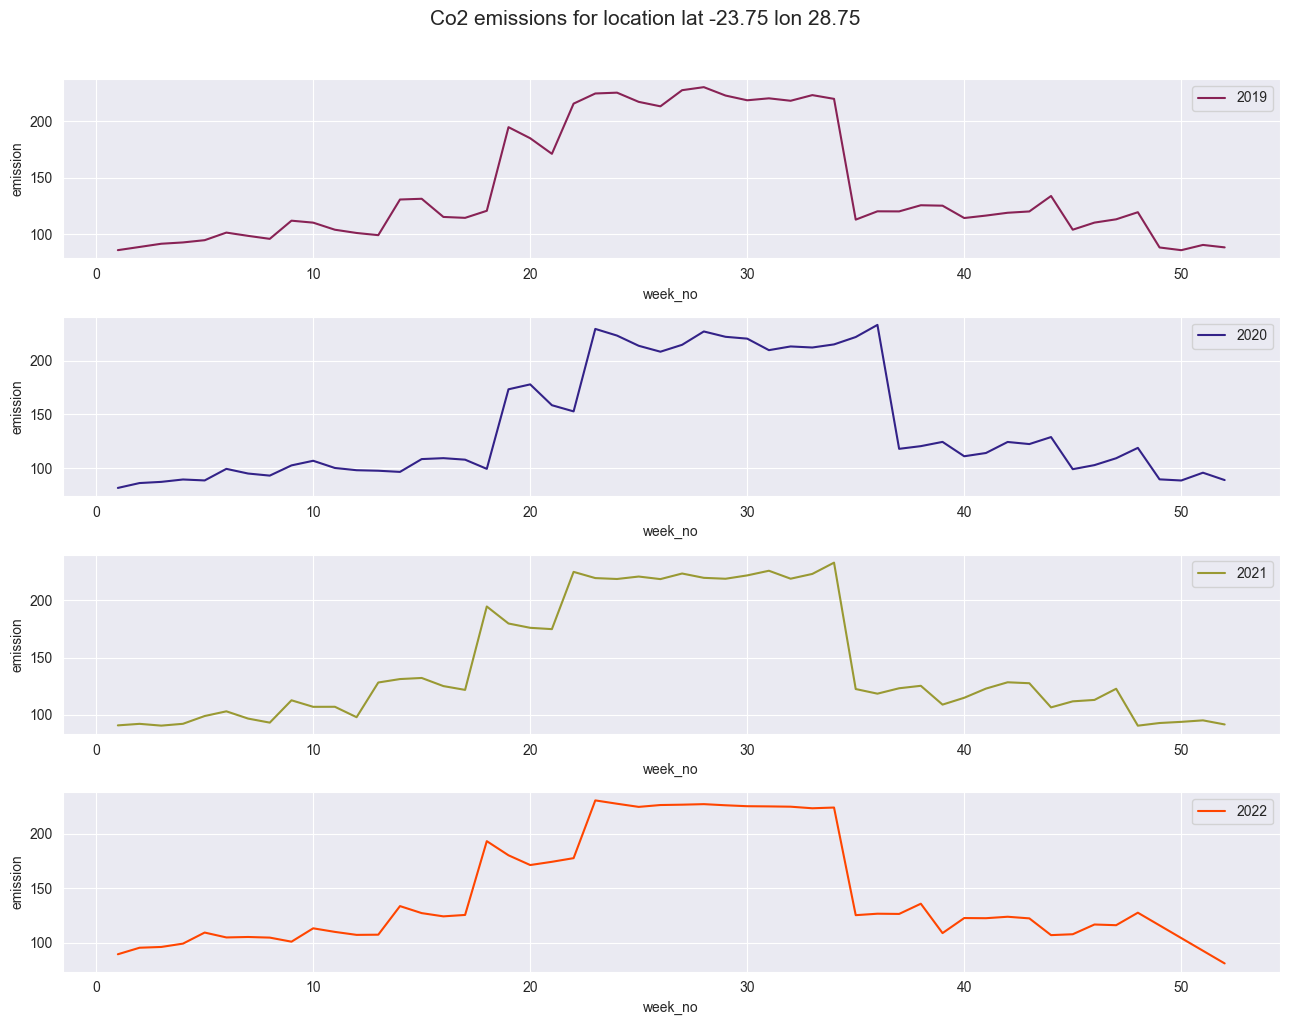

In [39]:
# Sample a unique location and visualize its emissions across the years
train.latitude, train.longitude = round(train.latitude, 2), round(train.longitude, 2)
sample_loc = train[(train.latitude == -23.73) & (train.longitude == 28.77)]

# Plot a line plot
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 4, ncols = 1, figsize = (13, 10))
fig.suptitle('Co2 emissions for location lat -23.75 lon 28.75', y=1.02, fontsize = 15)

for ax, data, year, color, in zip(axes.flatten(), sample_loc, sample_loc.year.unique(), ['#882255','#332288', '#999933' , 'orangered']):
  df = sample_loc[sample_loc.year == year]
  sns.lineplot(x=df.week_no,y= df.emission, ax = ax, label = year, color = color)
plt.legend()
plt.tight_layout()

<a name="Engineering"></a>
## 10. Feature engineering

Feature engineering involves creating new features from the raw data to better capture underlying patterns. In this project, we create features that capture spatial, temporal, and pollutant-specific trends. Examples include:
- **Rolling Means:** To smooth out short-term fluctuations.
- **Interaction Terms:** Such as ratios between pollutant measurements.
- **Temporal Features:** Extracting the week or year, and even seasonal indicators.
- **Spatial Features:** Creating a unique location identifier from latitude and longitude.

The following code demonstrates the creation of a rolling mean feature as an example.

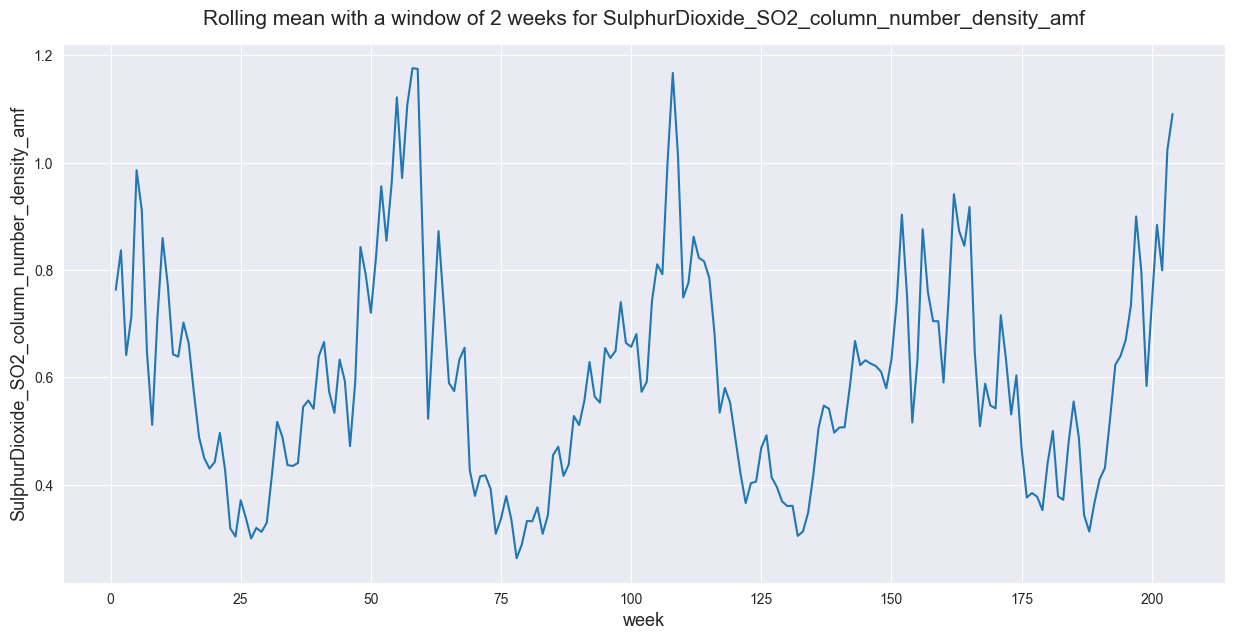

In [40]:
# Examples of feature engineering - Aggregations, cumulative differences, moving averages ...
# Lets explore the rolling mean
# First we create a unique location from lat lon
train['location'] = [str(x) + '_' + str(y) for x, y in zip(train.latitude, train.longitude)]

# Filter based on one location
example_loc = train[train.location == '-23.73_28.77']

# Calculate rolling mean for SulphurDioxide_SO2_column_number_density_amf with a window of 2 weeks
rolling_mean = example_loc['SulphurDioxide_SO2_column_number_density_amf'].rolling(window = 2).mean()

# Visualise rolling mean
plt.figure(figsize = (15, 7))
rolling_mean.plot()
plt.title('Rolling mean with a window of 2 weeks for SulphurDioxide_SO2_column_number_density_amf', y = 1.02, fontsize = 15)
plt.xlabel('week', y = 1.05, fontsize = 13)
plt.ylabel('SulphurDioxide_SO2_column_number_density_amf', x = 1.05, fontsize = 13)
plt.show()

 - There is a cyclic pattern from the above graph, which clearly shows that there is a pattern - This will be helpful to our model
 - With more research and domain knowledge generate useful features that can improve your model performance

 Other examples of feature engineering:
  - Creating cluster regions
  - Interactions between different pollutatnts - ratios, additions,subtractions...
  - Time series features

In [41]:
# Generate the above feature - rolling mean for all locations for both the train and test

# Feature engineering train
train_roll_mean = train.sort_values(by = ['location', 'year', 'week_no']).groupby(['location'])[train.columns[5:].tolist()].rolling(window = 2).mean().reset_index()
train_roll_mean.drop(['level_1', 'emission', 'location'], axis = 1, inplace = True)
train_roll_mean.columns = [col + '_roll_mean' for col in train_roll_mean.columns]

# Feature engineering test
test.latitude, test.longitude = round(test.latitude, 2), round(test.longitude, 2)
test['location'] = [str(x) + '_' + str(y) for x, y in zip(test.latitude, test.longitude)]
test_roll_mean = test.sort_values(by = ['location', 'year', 'week_no']).groupby(['location'])[test.columns[5:].tolist()].rolling(window = 2).mean().reset_index()
test_roll_mean.drop(['level_1', 'location'], axis = 1, inplace = True)
test_roll_mean.columns =  [col + '_roll_mean' for col in test_roll_mean.columns]
test_roll_mean.head()

,SulphurDioxide_SO2_column_number_density_roll_mean,SulphurDioxide_SO2_column_number_density_amf_roll_mean,SulphurDioxide_SO2_slant_column_number_density_roll_mean,SulphurDioxide_cloud_fraction_roll_mean,SulphurDioxide_sensor_azimuth_angle_roll_mean,SulphurDioxide_sensor_zenith_angle_roll_mean,SulphurDioxide_solar_azimuth_angle_roll_mean,SulphurDioxide_solar_zenith_angle_roll_mean,SulphurDioxide_SO2_column_number_density_15km_roll_mean,CarbonMonoxide_CO_column_number_density_roll_mean,...,Cloud_cloud_top_pressure_roll_mean,Cloud_cloud_top_height_roll_mean,Cloud_cloud_base_pressure_roll_mean,Cloud_cloud_base_height_roll_mean,Cloud_cloud_optical_depth_roll_mean,Cloud_surface_albedo_roll_mean,Cloud_sensor_azimuth_angle_roll_mean,Cloud_sensor_zenith_angle_roll_mean,Cloud_solar_azimuth_angle_roll_mean,Cloud_solar_zenith_angle_roll_mean
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.00013,0.43882,0.00005,0.09470,-49.02600,55.93510,-92.36411,26.77170,0.00002,0.02549,...,79559.85276,1581.44280,85797.36224,1244.57112,7.99207,0.25980,17.63036,45.73788,-89.10936,18.38737
2,0.00012,0.56813,0.00005,0.09466,-0.52002,44.99212,-88.07020,21.95860,0.00002,0.02503,...,81572.57216,1282.79200,87845.40093,966.94467,6.03470,0.24881,71.20704,49.73737,-84.13451,14.84474
3,0.00027,0.57377,0.00011,0.12280,-2.87484,47.10618,-82.84357,22.25336,0.00004,0.02369,...,70029.20519,2759.19246,76436.59160,2217.60082,6.52650,0.27011,32.44998,51.01341,-80.51563,19.53348
4,0.00034,0.60875,0.00016,0.14627,-8.86249,49.32330,-77.79334,22.96216,0.00007,0.02297,...,69815.08349,2791.47925,75984.38720,2275.47881,9.02194,0.28155,-12.15887,55.84850,-77.19218,22.99610


In [42]:
# Merge engineered features with train and test set

#Train
train_eng = train.sort_values(by = ['location', 'year', 'week_no'], ignore_index = True).merge(train_roll_mean, how = 'left',
                                                                                               left_index=True, right_index=True)

# Test
test_eng = test.sort_values(by = ['location', 'year', 'week_no'], ignore_index = True).merge(test_roll_mean, how = 'left',
                                                                                               left_index=True, right_index=True)

# Preview engineered test set
train_eng.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_base_pressure_roll_mean,Cloud_cloud_base_height_roll_mean,Cloud_cloud_optical_depth_roll_mean,Cloud_surface_albedo_roll_mean,Cloud_sensor_azimuth_angle_roll_mean,Cloud_sensor_zenith_angle_roll_mean,Cloud_solar_azimuth_angle_roll_mean,Cloud_solar_zenith_angle_roll_mean,emission_winsor_roll_mean,emission_log_roll_mean
0,ID_-23.73_28.77_2019_1,-23.73000,28.77000,2019,1,0.00017,0.71317,0.00010,0.22393,24.93944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID_-23.73_28.77_2019_2,-23.73000,28.77000,2019,2,-0.00016,0.81291,-0.00014,0.08028,16.62416,...,61658.89298,3820.33583,15.66697,0.29938,14.83040,45.82032,-89.77117,20.38106,87.46368,4.48246
2,ID_-23.73_28.77_2019_3,-23.73000,28.77000,2019,3,-0.00007,0.86031,-0.00006,0.16105,-13.23724,...,73729.74644,2233.97212,9.14070,0.24504,40.38474,38.66211,-86.74978,20.10527,90.29939,4.51402
3,ID_-23.73_28.77_2019_4,-23.73000,28.77000,2019,4,0.00015,0.42228,0.00009,0.04650,-13.53465,...,71780.27316,2155.99775,6.22549,0.22800,75.98650,47.51602,-77.74599,14.70756,92.30349,4.53584
4,ID_-23.73_28.77_2019_5,-23.73000,28.77000,2019,5,0.00002,1.00458,0.00003,0.21425,-13.47572,...,75698.41608,1986.58913,7.79724,0.23600,31.28314,55.24449,-74.67940,18.17604,93.88110,4.55257


<a name="Modelling"></a>
## 11.  Modelling
### Feature Selection

Feature selection helps identify the most relevant features for model training while removing redundant or less informative ones. We will:
- Use correlation analysis to remove highly correlated features.
- Use feature importance from a trained Random Forest model to select the most relevant predictors.


In [43]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Assuming train_eng is your engineered training dataset
# Separating features and target variable
#X = train_eng.drop(['ID_LAT_LON_YEAR_WEEK', 'location', 'emission'], axis=1).fillna(0)
X = train_eng.drop(['ID_LAT_LON_YEAR_WEEK', 'location', 'emission', 'emission_winsor', 'emission_log', 'emission_log_roll_mean', 'emission_winsor_roll_mean'], axis = 1).fillna(0)
y = train_eng['emission_log']

# Instantiate and fit the Random Forest model
rf = RandomForestRegressor(random_state=SEED, n_jobs=-1)
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display feature importances
print(feature_importances)

                                               Feature  Importance
1                                            longitude     0.59373
0                                             latitude     0.26312
84   NitrogenDioxide_NO2_column_number_density_roll...     0.08443
62                                Cloud_surface_albedo     0.02060
125                     Cloud_surface_albedo_roll_mean     0.00944
42                      UvAerosolIndex_sensor_altitude     0.00895
105           UvAerosolIndex_sensor_altitude_roll_mean     0.00130
79            CarbonMonoxide_sensor_altitude_roll_mean     0.00112
57                            Cloud_cloud_top_pressure     0.00103
85   NitrogenDioxide_tropospheric_NO2_column_number...     0.00053
117                Ozone_solar_azimuth_angle_roll_mean     0.00052
120                 Cloud_cloud_top_pressure_roll_mean     0.00052
101         Formaldehyde_solar_azimuth_angle_roll_mean     0.00043
89   NitrogenDioxide_absorbing_aerosol_index_roll_mean     0.0

In [44]:
# --- Step 2: Select the Features Based on a Threshold or Top N Criteria ---

# Option 1: Using an importance threshold (for example, keep features with importance >= 0.001)
threshold = 0.0001
selected_features = feature_importances[feature_importances['Importance'] >= threshold]['Feature'].tolist()

# Option 2: Alternatively, select the top N features (uncomment to use instead)
# top_n = 10
# selected_features = feature_importances.head(top_n)['Feature'].tolist()

print("\nSelected Features based on threshold:")
print(selected_features)


Selected Features based on threshold:
['longitude', 'latitude', 'NitrogenDioxide_NO2_column_number_density_roll_mean', 'Cloud_surface_albedo', 'Cloud_surface_albedo_roll_mean', 'UvAerosolIndex_sensor_altitude', 'UvAerosolIndex_sensor_altitude_roll_mean', 'CarbonMonoxide_sensor_altitude_roll_mean', 'Cloud_cloud_top_pressure', 'NitrogenDioxide_tropospheric_NO2_column_number_density_roll_mean', 'Ozone_solar_azimuth_angle_roll_mean', 'Cloud_cloud_top_pressure_roll_mean', 'Formaldehyde_solar_azimuth_angle_roll_mean', 'NitrogenDioxide_absorbing_aerosol_index_roll_mean', 'Cloud_cloud_top_height_roll_mean', 'UvAerosolIndex_solar_azimuth_angle_roll_mean', 'UvAerosolIndex_absorbing_aerosol_index_roll_mean', 'UvAerosolIndex_solar_zenith_angle_roll_mean', 'week_no', 'Cloud_cloud_top_height', 'CarbonMonoxide_H2O_column_number_density_roll_mean', 'SulphurDioxide_cloud_fraction_roll_mean', 'NitrogenDioxide_solar_azimuth_angle_roll_mean', 'SulphurDioxide_solar_zenith_angle_roll_mean', 'Formaldehyde_c

In [45]:
# --- Step 3: Finalize the Dataset with Selected Features ---

# Create the final feature set from train_eng using the selected features
# Fill missing values with the mean of each column
X_final = train_eng[selected_features].fillna(train_eng[selected_features].mean())
y_final = train_eng['emission_log']

print("\nFinal dataset features:")
print(X_final.head(0))
X_final.shape


Final dataset features:
Empty DataFrame
Columns: [longitude, latitude, NitrogenDioxide_NO2_column_number_density_roll_mean, Cloud_surface_albedo, Cloud_surface_albedo_roll_mean, UvAerosolIndex_sensor_altitude, UvAerosolIndex_sensor_altitude_roll_mean, CarbonMonoxide_sensor_altitude_roll_mean, Cloud_cloud_top_pressure, NitrogenDioxide_tropospheric_NO2_column_number_density_roll_mean, Ozone_solar_azimuth_angle_roll_mean, Cloud_cloud_top_pressure_roll_mean, Formaldehyde_solar_azimuth_angle_roll_mean, NitrogenDioxide_absorbing_aerosol_index_roll_mean, Cloud_cloud_top_height_roll_mean, UvAerosolIndex_solar_azimuth_angle_roll_mean, UvAerosolIndex_absorbing_aerosol_index_roll_mean, UvAerosolIndex_solar_zenith_angle_roll_mean, week_no, Cloud_cloud_top_height, CarbonMonoxide_H2O_column_number_density_roll_mean, SulphurDioxide_cloud_fraction_roll_mean, NitrogenDioxide_solar_azimuth_angle_roll_mean, SulphurDioxide_solar_zenith_angle_roll_mean, Formaldehyde_cloud_fraction_roll_mean, CarbonMonoxid

(74005, 64)

In [46]:
from sklearn.model_selection import train_test_split

# X_final: The DataFrame containing your selected features.
# y_final: The target variable, for instance, the log-transformed emissions.

# Split the data into training and test sets using a 80-20 split.
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=SEED)

# Print the shapes to verify the split.
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (59204, 64)
Test set size: (14801, 64)


## Model Development and Evaluation

We will train multiple models to compare their performance:
1. **Linear Regression** - A simple baseline model.
2. **Random Forest** - A non-linear ensemble model.
3. **XGBoost** - A boosting-based model that often performs well with tabular data.
4. **Light XGBoost** - Lighter version of XGBoost, Both which are gradient boosting frameworks

The models will be evaluated based on **Root Mean Squared Error (RMSE)**.


In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb # Import LightGBM

# Instantiate the models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=SEED, n_jobs=-1)
xgb_model = XGBRegressor(random_state=SEED, n_jobs=-1)
lgb_model = lgb.LGBMRegressor(random_state=SEED, n_jobs=-1) # Instantiate LightGBM

# Train the models
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train) # Train LightGBM

# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgb = lgb_model.predict(X_test) # Predictions from LightGBM

# Evaluate models
# def evaluate_model(y_true, y_pred, model_name):
#     rmse = np.sqrt(mean_squared_error(y_true, y_pred))
#     mae = mean_absolute_error(y_true, y_pred)
#     r2 = r2_score(y_true, y_pred)
#     print(f"🔥{model_name} - ✅RMSE: {rmse:.4f}, ✅MAE: {mae:.4f}, ✅R-squared: {r2:.4f}")

def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Print the model name
    print(f"🔥{model_name}")

    # Print the metrics below the model name
    print(f"   ✅RMSE: {rmse:.4f}")
    print(f"   ✅MAE: {mae:.4f}")
    print(f"   ✅R-squared: {r2:.4f}\n") # Add a newline for better spacing

print("=================Model Performance:=================")
evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")
evaluate_model(y_test, y_pred_lgb, "LightGBM") # Evaluate LightGBM


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15470
[LightGBM] [Info] Number of data points in the train set: 59204, number of used features: 64
[LightGBM] [Info] Start training from score 6.360370
=================Model Performance:=================
🔥Linear Regression
   ✅RMSE: 1.9549
   ✅MAE: 1.5607
   ✅R-squared: 0.3528

🔥Random Forest
   ✅RMSE: 0.2374
   ✅MAE: 0.0924
   ✅R-squared: 0.9905

🔥XGBoost
   ✅RMSE: 0.3074
   ✅MAE: 0.2158
   ✅R-squared: 0.9840

🔥LightGBM
   ✅RMSE: 0.5165
   ✅MAE: 0.3921
   ✅R-squared: 0.9548



#### Final Model Training

After evaluating model performances, we will retrain the best-performing model on the entire training dataset. This ensures that the model benefits from the maximum available data before making final predictions.


In [48]:
# Create a DataFrame combining true values and predictions
results_df = pd.DataFrame({
    'True Value': y_test.values,             # true target values from the test set
    'Predicted Value': y_pred_rf             # predictions from the Random Forest model
})
results_df.head(2)

,True Value,Predicted Value
0,4.13567,4.07363
1,6.67239,6.72323


In [49]:
# Calculate error metrics
results_df['Error'] = results_df['Predicted Value'] - results_df['True Value']
results_df['Absolute Error'] = results_df['Error'].abs()
results_df['Squared Error'] = results_df['Error'] ** 2

In [50]:
# Display the first few rows of the results DataFrame
print("Combined Results (first 5 rows):")
print(results_df.head(5))

Combined Results (first 5 rows):
   True Value  Predicted Value    Error  Absolute Error  Squared Error
0     4.13567          4.07363 -0.06203         0.06203        0.00385
1     6.67239          6.72323  0.05084         0.05084        0.00258
2     9.88359          9.80600 -0.07759         0.07759        0.00602
3     7.38605          7.59762  0.21157         0.21157        0.04476
4     0.66489          0.67213  0.00724         0.00724        0.00005


In [51]:
# Copy X_test to preserve the original test set
pred_errors = X_test.copy()

# Add the true emission values (ensure alignment by using .values)
pred_errors['emission'] = y_test.values

# Add the model's predictions (using y_pred_rf which are the predictions from your Random Forest model)
pred_errors['prediction'] = y_pred_rf

# Calculate the absolute error between predictions and true values
pred_errors['error'] = abs(pred_errors['prediction'] - pred_errors['emission'])

# Retain only the desired columns for analysis
pred_errors = pred_errors[['latitude', 'longitude', 'year', 'week_no', 'emission', 'prediction', 'error']]

# Sort the results by 'error' in descending order to see the worst predictions first
pred_errors.sort_values(by='error', ascending=False, inplace=True)

# Display the top 5 rows with the highest errors
print(pred_errors.head())

       latitude  longitude  year  week_no  emission  prediction   error
57537 -29.73000   31.07000  2021       34  10.03556     4.79301 5.24255
57586 -29.73000   31.07000  2022       31  10.09965     5.09868 5.00097
71752 -33.03000   27.87000  2019        3   9.40323     4.59323 4.80999
71759 -33.03000   27.87000  2019       10   9.43717     4.66938 4.76779
61479 -29.93000   30.97000  2022       29  10.65542     6.32767 4.32774


### Making Predictions on the Test Set
Using the trained model, we will generate predictions on the test dataset. The results will be saved for further analysis.

In [52]:
import pandas as pd
import numpy as np

# --- Step 1: Prepare the Test Data ---
# For prediction, drop columns that are not used as predictors.
# Ensure that the same selected features used during training are applied.
# Here, we drop 'ID_LAT_LON_YEAR_WEEK' and 'location'. Adjust if necessary.
#X_test_final = test_eng.drop(['ID_LAT_LON_YEAR_WEEK', 'location'], axis=1).fillna(0)
X_test_final = test_eng[selected_features].fillna(0)
# --- Step 2: Make Predictions using the Best Model ---
# Assuming rf_model is your best-performing Random Forest model, trained earlier.
test_predictions = rf_model.predict(X_test_final)


In [53]:
# --- Step 3: Prepare the Submission DataFrame ---
# The submission format should have two columns:
# 'ID_LAT_LON_YEAR_WEEK' (unique identifier) and 'emission' (predicted target)
submission = pd.DataFrame({
    'ID_LAT_LON_YEAR_WEEK': test_eng['ID_LAT_LON_YEAR_WEEK'],  # unique ID from test data
    'emission': test_predictions  # model predictions (log-scale, if applicable)
})
submission.head(2)


,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-23.53_27.47_2019_1,4.88291
1,ID_-23.53_27.47_2019_2,4.55651


In [54]:
# If your model was trained on a log-transformed target, you may want to convert predictions back
# For example, if y = log(emission + 1), then uncomment the following line:
submission['emission'] = np.expm1(submission['emission'])
submission.head(2)

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-23.53_27.47_2019_1,131.01372
1,ID_-23.53_27.47_2019_2,94.25056


In [55]:
# --- Step 4: Save the Submission File ---
submission.to_csv('FinalSubmission.csv', index=False)
print("Submission file 'FinalSubmission.csv' created successfully!")

Submission file 'FinalSubmission.csv' created successfully!


### Conclusion

- The **Random Forest** demonstrated the best performance based on RMSE.
- The model was retrained on the entire dataset and used to generate final predictions.
- The predictions were saved for further analysis.

### Future Work

To improve model accuracy, we can explore:
1. **Additional Feature Engineering** – Incorporating climate or economic variables.
2. **Hyperparameter Tuning** – Using grid search for optimized parameters.
3. **Deep Learning Approaches** – Testing LSTMs or Transformer-based models.

This notebook provides a structured and reproducible pipeline for **carbon emission prediction in Africa** using satellite data.


## **Module II: Hyperparameter Tuning**

In [56]:
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.stats import randint
#Define the hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 7),
    'min_samples_leaf': randint(1, 4),
    'max_features': ['sqrt', 'auto'],
    'bootstrap': [True, False]
}

In [57]:
# prompt: Setup random search with our parameter grid

from sklearn.model_selection import RandomizedSearchCV

# Assuming rf_model is your RandomForestRegressor instance
# and X_train, y_train are your training data
#rf_model = RandomForestRegressor(random_state=SEED, n_jobs=-1)

# Create the random search object
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=20,  # Number of parameter settings that are sampled
    cv=3,       # Number of cross-validation folds
    scoring='neg_mean_squared_error',  # Use a suitable scoring metric
    verbose=1,   # Control the verbosity of the search process
    n_jobs=-1,    # Use all available CPU cores
    random_state=SEED  # For reproducibility
)

# Perform the random search
random_search.fit(X_train, y_train)

# Get the best parameters and the best score

best_cv_rmse = np.sqrt(-random_search.best_score_) # Convert best_score_ (negative MSE) to RMSE
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)
print("\nBest Cross-Validated RMSE:", best_cv_rmse)

# Use the best model for predictions (optional)
best_rf_model = random_search.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best score: -1.44137103062734

Best Cross-Validated RMSE: 1.2005711268506085


In [61]:
#Evaluate the Best Model on the Test Set ---
best_rf_model = random_search.best_estimator_
y_pred_bm = best_rf_model.predict(X_test)
# Calculate MSE first, then take the square root for RMSE
test_mse = mean_squared_error(y_test, y_pred_bm) # Remove squared=False
test_rmse = np.sqrt(test_mse) 
#test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print("\nTest RMSE for Tuned Random Forest:", test_rmse)


Test RMSE for Tuned Random Forest: 1.1397920793328735


In [62]:
# Create a DataFrame combining true values and predictions based on the Best random forest model

# y_test: True target values from the test set
# y_pred_bm: Predictions from the best Random Forest model (after hyperparameter tuning)

# Create a DataFrame combining true values and predictions
results_df_bm = pd.DataFrame({
    'True Value': y_test.values,
    'Predicted Value': y_pred_bm
})

# Display the first few rows of the DataFrame
print(results_df_bm.head(2))


   True Value  Predicted Value
0     4.13567          3.62808
1     6.67239          7.62923


In [63]:
# Calculate error metrics
results_df_bm['Error'] = results_df_bm['Predicted Value'] - results_df_bm['True Value']
results_df_bm['Absolute Error'] = results_df_bm['Error'].abs()
results_df_bm['Squared Error'] = results_df_bm['Error'] ** 2
# Display the first few rows of the results DataFrame
print("Combined Results (first 5 rows):")
print(results_df_bm.head(5))

Combined Results (first 5 rows):
   True Value  Predicted Value    Error  Absolute Error  Squared Error
0     4.13567          3.62808 -0.50758         0.50758        0.25764
1     6.67239          7.62923  0.95684         0.95684        0.91554
2     9.88359          8.89285 -0.99074         0.99074        0.98156
3     7.38605          6.58027 -0.80578         0.80578        0.64928
4     0.66489          1.55666  0.89177         0.89177        0.79525


In [64]:
# prompt: Make predictions on the test set based on the best random forest model 

# Assuming 'best_rf_model' is the best RandomForestRegressor from hyperparameter tuning
# and 'X_test_final' is your prepared test set

test_predictions = best_rf_model.predict(X_test_final)

# Create the submission DataFrame
submission_fineTuned = pd.DataFrame({
    'ID_LAT_LON_YEAR_WEEK': test_eng['ID_LAT_LON_YEAR_WEEK'],
    'emission': test_predictions
})
submission_fineTuned.head(2)

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-23.53_27.47_2019_1,5.91429
1,ID_-23.53_27.47_2019_2,6.29839


In [65]:
# Convert predictions back from log scale if necessary
submission_fineTuned['emission'] = np.expm1(submission_fineTuned['emission'])
submission_fineTuned.head(2)

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-23.53_27.47_2019_1,369.29025
1,ID_-23.53_27.47_2019_2,542.69416


In [66]:
# Save the submission file
submission.to_csv('FinalSubmission_tuned.csv', index=False)
print("Submission file 'FinalSubmission_tuned.csv' created successfully!")

Submission file 'FinalSubmission_tuned.csv' created successfully!


====